# Notebook 7 - Polaritons
-------------


In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sp_linalg

# Build polariton Hamiltonian
def build_Hpol(H_mat, wc, nph, p_mat, A_0):
    # H_mat: Matter Hamiltonian
    # wc: cavity frequency
    # nph: number of photons
    # p_mat: momentum operator in the matter basis
    # A_0: mode strength

    # ---------------------
    # Light-Matter Diagonal
    # ---------------------
    e_tol = 1e-9
    # Matter
    H_pol_mat_d = np.kron(np.eye(nph), H_mat)

    # Photons
    H_ph_d = (np.diag(np.arange(0., nph*wc-e_tol, wc) + 0.5*wc) +
            1./2. * np.diag(2.*np.arange(0., nph*A_0**2-e_tol, A_0**2) + A_0**2))
    H_pol_ph_d = np.kron(H_ph_d, np.eye(H_mat.shape[0]))

    # ----------------------
    # A^2 term off-diagonal
    # ----------------------
    # sqrt(n+1) factors from the application of the bosonic operator
    n_quad = (np.sqrt(np.arange(0, nph-2, 1) + 1) * np.sqrt(np.arange(0, nph-2, 1) + 2))
    M_quad = np.diag(n_quad, k=2)

    H_A2 = 0.5 * np.kron(M_quad, np.eye(H_mat.shape[0]))
    H_A2 += np.transpose(H_A2).conj()

    # ----------
    # P.A term
    # ----------
    # sqrt(n+1) factors from the application of the bosonic operator
    n_sqrt = np.sqrt(np.arange(0, nph-1, 1) + 1)
    M_sqrt = np.diag(n_sqrt, k=1)

    H_PA = np.kron(M_sqrt, p_mat)
    H_PA += H_PA.T.conj()

    # -----------------
    # Full Hamiltonian
    # -----------------
    H_pol = H_pol_mat_d + H_pol_ph_d + A_0 * H_PA + A_0**2 * H_A2
    return H_pol

def diagonalize_H(H_pol, n_eig=10, sparse=False):
    if not sparse:
        ev_N, es_MN = np.linalg.eig(H_pol)
    else:
        H_sparse = sp.csr_matrix(H_pol)
        ev_N, es_MN = sp_linalg.eigs(H_sparse, k=n_eig, which='SM', tol=1e-7)
    sort_N = np.argsort(ev_N)
    ev_N = ev_N[sort_N]
    es_MN = es_MN[:, sort_N]

    return np.array(ev_N), np.array(es_MN)

## A. 7.1
-------------
We should use the functions above to first build the Hamiltonian and then diagonalize it. After that we plot the eigenvalues (after sorting, to avoid weird jumps in the plotting)

In [2]:
import matplotlib.pyplot as plt
E_exc = 1.
H_mat = np.array([[0., 0.],[0., E_exc]])
wc = np.linspace(0.5, 1.5, 100)
nph = 3
p_mat = 0.1 * np.array([[0., 1.],[1., 0]])
A_0 = 0.3

# Plot the first 5 eigenvalues as a function of frequency
n_sel = 5
ev_sel = []
for w in wc:
    H = build_Hpol(H_mat=H_mat, wc=w, nph=nph, p_mat=p_mat, A_0=A_0)
    ev, es = diagonalize_H(H)
    ev_sel.append(ev)


# Photon lines as guide for the eye
n_l = 2
ph_l = []
for l in range(n_l+1):
    y_l = (l + 0.5)*(wc + A_0**2)
    plt.plot(wc, y_l, ls='--', c='gray')

plt.plot(wc, ev_sel)

plt.xlabel('Cavity Frequency')
plt.ylabel('Energy')
plt.title('Polaritonic Eigenstates')
plt.show()

In [3]:
def build_H_phonoriton(E_exc, E_pn, nexc, npn, pme_epn, pme_eph, pme_phn, pme_pnph):
    # E_exc: excitonic transition energy,
    # E_pn: phonon mode energy
    # nexc: number of excitonic states (including groundstate),
    # npn: number of Fock states for phonons,
    # pme_epn: matrix element value for el-pn,
    # pme_eph: matrix element value for el-ph,
    # pme_phn: matrix element value for pn-ph,
    # pme_pnph: matrix element value for el-pn-ph

    # --------
    # Diagonal
    # --------
    e_tol = 1e-9
    H_exc = np.diag(np.arange(0, nexc*E_exc-e_tol, E_exc))
    H_pn = np.diag(np.arange(0., npn*E_pn-e_tol, E_pn))

    H_mat = np.kron(np.identity(npn), H_exc) + np.kron(H_pn, np.identity(nexc))

    # -----------------------
    # Exciton-Phonon Coupling
    # -----------------------
    H_exc_temp = np.zeros((nexc, nexc))
    H_exc_temp[0, 0] = 0.
    # Assumes that a given exciton does not scatter with itself through
    # a phonon, i.e. is stable at equilibrium
    H_exc_temp[0, 1:nexc] = H_exc_temp[1:nexc, 0] = 1.
    # approx: Same coupling all excitons

    n_sqrt = np.sqrt(np.arange(0, npn, 1) + 1)
    np1, np2 = np.meshgrid(n_sqrt, n_sqrt)

    H_pn_temp = pme_epn * np2 * np.eye(npn, k=1)
    H_pn_temp += np.transpose(H_pn_temp.conj())
    H_excpn_c = np.kron(H_pn_temp, H_exc_temp)
    H_mat += H_excpn_c

    # --------------
    # Exciton-Photon
    # --------------
    p_excph_temp = np.zeros_like(H_exc)
    # approx: all excitons have the same coupling
    p_excph_temp[0, 1:] = pme_eph
    p_excph_temp[1:, 0] = np.conj(pme_eph)
    P_excph_c = np.kron(np.identity(npn), p_excph_temp)   # Identity for the phonons

    P_mat = P_excph_c.copy()

    # -------------
    # Phonon-Photon
    # -------------
    H_pnph_temp = pme_pnph * np2 * np.eye(npn, k=1)
    H_pnph_temp += np.transpose(H_pnph_temp.conj())
    H_pnph_c =  np.kron(H_pnph_temp, np.identity(nexc))   # Identity for the excitons
    P_mat += H_pnph_c

    # ---------------------
    # Phonoritonic Coupling
    # ---------------------
    H_phn_temp = pme_phn * np2 * np.eye(npn, k=1)
    H_phn_temp += np.transpose(H_phn_temp.conj())
    p_exc = np.zeros_like(H_exc)
    # approx: all excitons have the same coupling
    p_exc[0, 1:] = 1.
    p_exc[1:, 0] = 1.

    H_phn_c = np.kron(H_phn_temp, p_exc)
    P_mat += H_phn_c

    return H_mat, P_mat

## A. 7.2
-------------
The suggested function, builds the full matrix for the matter (consisting of both exciton and phonon) together with the matrix for the momentum, which is the one that is directly related to the coupling with light. The momentum matrix contains exciton-photon, exciton-phonon, phonon-photon and exciton-phonon-photon terms. Each of such a term is parameterized in the function arguments.

In the following we build the polaritonic Hamiltonian and we then diagonalize it. After that we plot the eigenvalues as a function of the cavity frequency, can you spot the phonoriton?


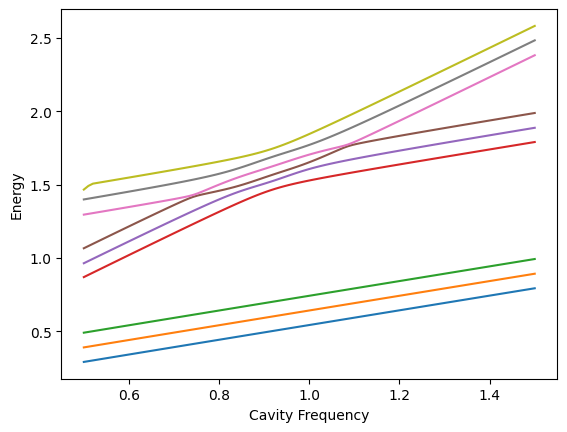

In [4]:
nexc=2
npn=3
H_mat, P_mat = build_H_phonoriton(E_exc=1., E_pn=0.1, nexc=nexc, npn=npn, pme_epn=0., pme_eph=0.1, pme_phn=0.1, pme_pnph=0.)
wc = np.linspace(0.5, 1.5, 100)
A_0 = 0.3
nph = 4
# Plot the first 9 eigenvalues as a function of frequency
n_sel = 9
ev_sel = []
es_sel = []
for w in wc:
    H = build_Hpol(H_mat=H_mat, wc=w, nph=nph, p_mat=P_mat, A_0=A_0)
    ev, es = diagonalize_H(H)
    i_sort = np.argsort(ev)
    ev = ev[i_sort]
    es = es[:, i_sort]
    ev_sel.append(ev[:n_sel])
    es_sel.append(es)

plt.plot(wc, ev_sel)
plt.xlabel('Cavity Frequency')
plt.ylabel('Energy')
plt.show()

Now in order to evaluate (and plot the polaritonic contribution) we need to analyze the wavefunctions correspoding to the state of interest. It is important to remember that in our representation we have three running indices referring to the exciton, phonon, photon quantum numbers, respectively. The most internal index is the one for the exciton, followed by the one for the phonon and finally the one from the photon (this is the convention used in the builder functions, check!). 

Noted the above we then could plot the eigenstates as barplots and attribute the different weights to the different particle components. Let's analyze the groundstate and the 3rd and 4th excited states at the polaritonic intersections.

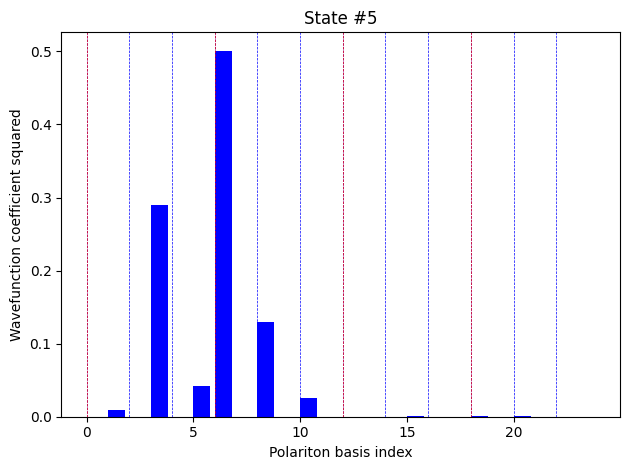

In [5]:
e_cut =  1.   # Cavity energy at which you want to analyze the weights
iwc = np.argmin(np.abs(wc-e_cut))
i_es = 5
y = np.abs(np.array(es_sel)[iwc, :, i_es])**2

plt.bar(np.arange(0, nexc * npn * nph, 1), y, color='blue', align='edge')

# Line to distinguish phonon number change
for j in np.arange(0, nexc * npn * nph, nexc):
    plt.axvline(j, ls='--', c='b', lw=0.5)
# Line to distinguish photon number change
for j in np.arange(0, nexc * npn * nph, nexc * npn):
    plt.axvline(j, ls='--', c='r', lw=0.5)

plt.xlabel('Polariton basis index')
plt.ylabel('Wavefunction coefficient squared')
plt.title('State #%s' %i_es)


plt.tight_layout()
plt.show()
